# Predictive Models for Acute Oral Systemic Toxicity

The objective of this project is to leverage the combined expertise of the international modeling community to develop predictive models for acute oral toxicity based on regulatory needs submitted by ICCVAM agencies. Models developed for the project will be evaluated, and those meeting defined criteria will be used to generate consensus toxicity predictions of acute oral toxicity endpoints of interest to regulatory agencies. 

Based on the range of regulatory criteria and decision contexts used by ICCVAM agencies, a total of five different modeling endpoints have been identified. Participants can build models to predict one or more of the following endpoints:

+ Very toxic (<50\ mg/kg vs. all others)
+ Nontoxic (>2000\ mg/kg vs. all others)
+ LD50 point estimates
+ Hazard categories under the EPA classification system (n=4) 
+ Hazard categories under the GHS classification system (n=5; Category 5 and Not Classified combined into a single category)

## Data Exploration

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/training_set.csv', sep='\t')

In [5]:
df.head()

,CASRN,DTXSID,Chemical_Name,Structure_Source,Canonical_QSARr,Salt_Solvent,InChI_Code_QSARr,InChI_Key_QSARr,LD50_mgkg,EPA_category,GHS_category,very_toxic,nontoxic
0,100-00-5,DTXSID5020281,1-Chloro-4-nitrobenzene,EPA_DSSTox,[O-][N+](=O)C1C=CC(Cl)=CC=1,?,InChI=1S/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,CZGCEKJOLUNIFY-UHFFFAOYSA-N,460.0,False,False,2.0,4.0
1,100-01-6,DTXSID8020961,4-Nitroaniline,EPA_DSSTox,NC1=CC=C(C=C1)[N+]([O-])=O,?,InChI=1S/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4...,TYMLOMAKGOJONV-UHFFFAOYSA-N,750.0,False,False,3.0,4.0
2,100-02-7,DTXSID0021834,4-Nitrophenol,EPA_DSSTox,[O-][N+](=O)C1C=CC(O)=CC=1,?,"InChI=1S/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",BTJIUGUIPKRLHP-UHFFFAOYSA-N,170.0,False,False,2.0,3.0
3,100-14-1,DTXSID4025745,4-Nitrobenzyl chloride,EPA_DSSTox,[O-][N+](=O)C1C=CC(CCl)=CC=1,?,InChI=1S/C7H6ClNO2/c8-5-6-1-3-7(4-2-6)9(10)11/...,KGCNHWXDPDPSBV-UHFFFAOYSA-N,1809.0,False,False,3.0,4.0
4,100-15-2,DTXSID7025635,N-Methyl-4-nitroaniline,EPA_DSSTox,CNC1C=CC(=CC=1)[N+]([O-])=O,?,InChI=1S/C7H8N2O2/c1-8-6-2-4-7(5-3-6)9(10)11/h...,XIFJZJPMHNUGRA-UHFFFAOYSA-N,NaN,True,False,3.0,5.0


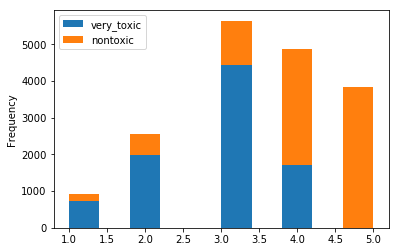

In [16]:
df[['very_toxic', 'nontoxic']].plot.hist(stacked=True)